In [1]:
import torch
import torch.nn as nn
import torchaudio
from pathlib import Path
import pandas as pd
import IPython.display as ipd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz

In [ ]:
!tar -xf nsynth-test.jsonwav.tar.gz

In [2]:
class NSynthDataSet:
  def __init__(self, path):
    if isinstance(path, str):
      path = Path(path)
    self.path = path
    json_path = path / "examples.json"
    # self.meta = pd.read_json(json_path).to_dict()
    self.meta= pd.read_json(json_path)
    self.file_list = list(self.path.rglob('*.wav'))
    
  def __getitem__(self, idx):
    fn = self.file_list[idx]
    audio, sr = torchaudio.load(fn)
    pitch = self.meta[fn.stem]['pitch']
    pitch = torch.tensor(pitch, dtype=torch.long)
    return audio, pitch
  
  def __len__(self):
    return len(self.meta.keys())

dataset = NSynthDataSet(Path('nsynth-test'))

In [3]:
dataset[0]

(tensor([[ 0.0007, -0.0003,  0.0009,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor(41))

In [32]:
audio, pitch = dataset[2000]
ipd.Audio(audio, rate=16000)

In [ ]:
df = pd.read_json(Path('nsynth-test')/ "examples.json")
df['bass_synthetic_068-049-025']

In [4]:
train_loader = DataLoader(dataset, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
# test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
batch = next(iter(train_loader))

In [5]:
audio, pitch = batch

audio.shape, pitch.shape

(torch.Size([128, 1, 64000]), torch.Size([128]))

## About Transposed Conv

In [ ]:
dummy = torch.arange(49).view(1, 7,7).float()

plt.imshow(dummy[0])
print(dummy)

In [ ]:
kernel_size = 3
padding_size= 2
stride_size = 2
conv_layer = nn.Conv2d(1, 1, kernel_size, padding=padding_size, stride=stride_size)
conv_layer.weight.data = torch.ones_like(conv_layer.weight.data)

In [ ]:
conv_output = conv_layer(dummy)

In [ ]:
plt.imshow(conv_output[0].detach())

In [ ]:
# kernel_size = 3
padding_size= 2
# stride_size = 2

conv_t_layer = nn.ConvTranspose2d(1,1, kernel_size, padding=padding_size, stride=stride_size)
t_output = conv_t_layer(conv_output)

plt.imshow(t_output[0].detach())

In [ ]:
conv_t_layer(conv_layer(dummy)).shape, dummy.shape

In [72]:
torch.max(spec)

tensor(0.6691)

## NSynth Autoencoder

In [6]:
class SpecModel(nn.Module):
  def __init__(self, n_fft, hop_length):
    super().__init__()
    self.spec_converter = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    self.db_converter = torchaudio.transforms.AmplitudeToDB(stype='power')

  def forward(self, audio_sample):
    spec = self.spec_converter(audio_sample)
    db_spec = self.db_converter(spec)
    return db_spec

class Conv2dNormPool(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.LeakyReLU(0.1)
    
  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = self.activation(x)
    return x
  
class Conv2dNormTransposePool(Conv2dNormPool):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__(in_channels, out_channels, kernel_size, padding, stride)
    self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)

  
class AutoEncoder(nn.Module):
  def __init__(self, n_fft, hop_length, hidden_size=256):
    super().__init__()
    self.spec_model = SpecModel(n_fft, hop_length)
    self.encoder = nn.Sequential()
    self.pitch_embedder = nn.Embedding(121, hidden_size//2)
    self.num_channels = [1] + [128] * 3 + [256] * 3 + [512] * 2 + [1024]
    i = 0
    self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (5,5), 2, (2,2) ))
    for i in range(1,7):
      self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (4,4), 1, (2,2) ))
    i = 7
    self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (2,2), 0, (2,2) ))
    i = 8
    self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (1,1), 0, (1,1) ))
    self.final_layer = nn.Linear(hidden_size * 2, hidden_size) 
    self.decoder = nn.Sequential(      
        Conv2dNormTransposePool(in_channels=self.num_channels[-1] + hidden_size//2, out_channels=self.num_channels[-2], kernel_size=(2,1), padding=0, stride=(2,2))
    )
    i = 0
    self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (2,2), 0, (2,2)))
    for i in range(1,7):
      self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (4,4), 1, (2,2)))
    self.decoder.add_module("final_module",  nn.ConvTranspose2d(in_channels=self.num_channels[1], out_channels=1, kernel_size=(4,4), padding=1, stride=(2,2)),)


  def forward(self, x, pitch):
    spec = self.spec_model(x)
    spec = spec[:,:,:-1] # to match 512
    spec /= 80
    spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
    out = self.encoder(spec)

    latent = self.final_layer(out.view(out.shape[0], -1))
    latent = torch.cat([latent, self.pitch_embedder(pitch)], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = self.decoder(latent)
    return recon_spec, spec
  
model = AutoEncoder(1024, 256, 1024)
recon_spec, spec = model(audio, pitch)
recon_spec.shape, spec.shape

(torch.Size([128, 1, 512, 256]), torch.Size([128, 1, 512, 256]))

In [62]:
x = audio
self = model

spec = self.spec_model(x)
spec = spec[:,:,:-1] # to match 512
spec /= 80
print(spec.shape)
spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
print(spec.shape)
out = self.encoder(spec)
print(out.shape)
# latent = self.final_layer(out.view(out.shape[0], -1))
latent = self.final_layer(out.flatten(1,3))
print(latent.shape)
latent = torch.cat([latent, self.pitch_embedder(pitch)], dim=-1)
latent = latent.view(latent.shape[0], -1, 1, 1)
print(latent.shape)

torch.Size([64, 1, 512, 251])
torch.Size([64, 1, 512, 256])
torch.Size([64, 1024, 2, 1])
torch.Size([64, 1024])
torch.Size([64, 1536, 1, 1])


In [68]:
decoder_intermediate_output = self.decoder[:1](latent)
decoder_intermediate_output.shape

torch.Size([64, 512, 2, 1])

In [ ]:
spec = model.spec_model(audio)
spec.shape
spec = spec[:,:,:-1] # to match 512
spec /= 80
spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
out = model.encoder(spec)

out = out.reshape(out.shape[0], out.shape[1], -1)
latent = model.final_layer(out.view(out.shape[0], -1))
latent = torch.cat([latent, pitch], dim=-1)
latent = latent.unsqueeze(-1).unsqueeze(-1)

recon_spec = model.decoder(latent)
spec.shape, recon_spec.shape

In [ ]:
class WeightedSpecLoss:
  def __init__(self, fft_size=1024, sr=16000, device='cuda'):
    self.weight = torch.ones(fft_size//2).to(device)
    self.weight[:fft_size//4] = torch.linspace(10,1,fft_size//4)

  def __call__(self, pred, target):
    mse = (pred-target)**2
    mse *= self.weight[:, None]
    return mse.mean()
  
loss_calculator = WeightedSpecLoss()
loss_calculator(recon_spec.cuda(), spec.cuda())

In [ ]:
plt.plot(loss_calculator.weight.cpu())

In [ ]:
from tqdm.auto import tqdm

num_epochs = 5
device = 'cuda'
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(dataset, batch_size=8, num_workers=4, shuffle=True, pin_memory=True)

for epoch in tqdm(range(num_epochs)):
  for batch in train_loader:
    audio, pitch = batch
    recon_spec, spec = model(audio.to(device), pitch.to(device))
    loss = loss_calculator(recon_spec, spec)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
torch.save(model.state_dict(), 'autoencoder.pt')

In [ ]:
plt.imshow(recon_spec[4,0].detach().cpu(), origin='lower')

## Download pretrained model
- The model was trained about 1800k iterations with entire training set

In [53]:
!gdown 13it0VrccbE5QkdEGTlHZjSQFZLZTy1uu

Downloading...
From (uriginal): https://drive.google.com/uc?id=13it0VrccbE5QkdEGTlHZjSQFZLZTy1uu
From (redirected): https://drive.google.com/uc?id=13it0VrccbE5QkdEGTlHZjSQFZLZTy1uu&confirm=t&uuid=1809ae4d-04bf-475e-ba26-c1f3b8976c7c
To: /home/teo/userdata/git_libraries/ant5015-2023/notebooks/autoencoder_last.pt
100%|██████████████████████████████████████| 67.5M/67.5M [00:08<00:00, 8.01MB/s]


In [57]:
pretrained_weights = torch.load('autoencoder_last.pt', map_location='cpu')
model.load_state_dict(pretrained_weights)
model.eval()

AutoEncoder(
  (spec_model): SpecModel(
    (spec_converter): Spectrogram()
    (db_converter): AmplitudeToDB()
  )
  (encoder): Sequential(
    (conv_norm0): Conv2dNormPool(
      (conv): Conv2d(1, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (conv_norm1): Conv2dNormPool(
      (conv): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (conv_norm2): Conv2dNormPool(
      (conv): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (conv_norm3): Conv2dNormPool(
      (c

## Test Audio reconstruction

In [10]:
test_loader = DataLoader(dataset, batch_size=64, num_workers=4,pin_memory=True)

test_batch = next(iter(test_loader))

In [58]:
model.cpu()
audio, pitch = test_batch
model.eval()
with torch.no_grad():
  recon_spec, spec = model(audio, pitch)

Text(0.5, 1.0, 'Original Input')

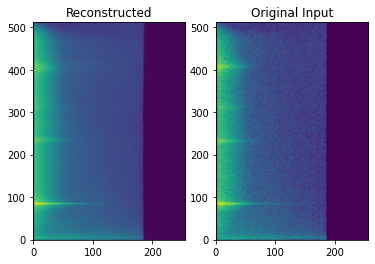

In [61]:
sample_id = 1

plt.subplot(1,2,1)
plt.imshow(recon_spec[sample_id, 0], origin='lower', aspect='auto')
plt.title('Reconstructed')
plt.subplot(1,2,2)
plt.imshow(spec[sample_id, 0], origin='lower', aspect='auto')
plt.title('Original Input')


Text(0.5, 1.0, 'Reconstructed')

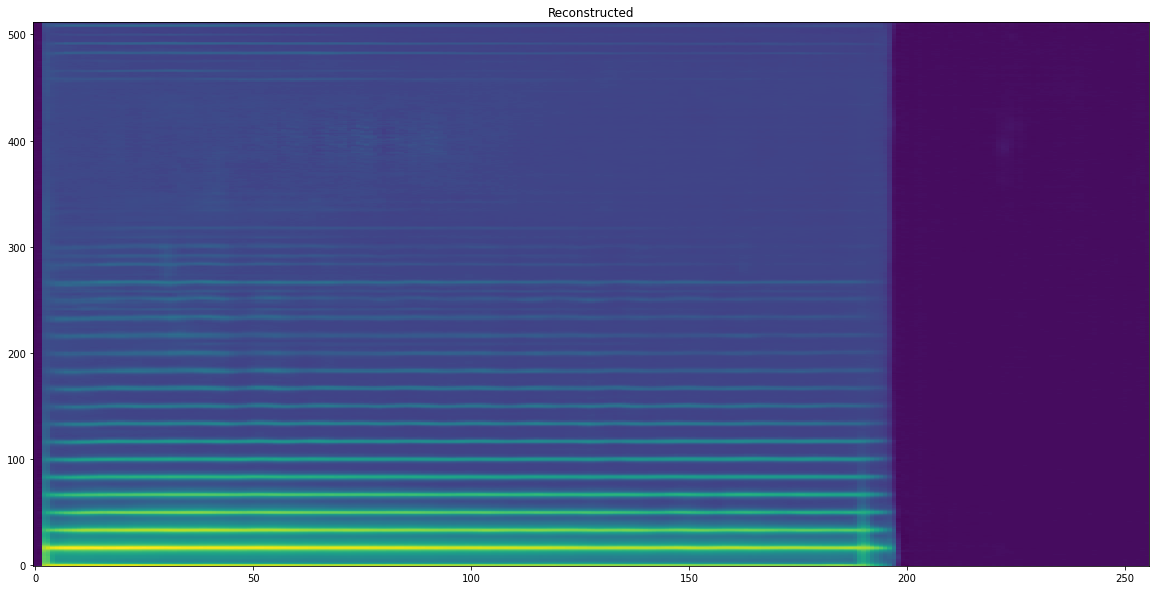

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(recon_spec[sample_id, 0], origin='lower', aspect='auto', interpolation='none')
plt.title('Reconstructed')

### Convert Spectrogram to Wav using Griffin-Lim Algorithm

In [16]:
def network_output_to_audio(spec):
  rescaled_spec = spec * 80
  padded_spec = nn.functional.pad(rescaled_spec, (0,0, 0,1), value=-100)
  magnitude_spec = torchaudio.functional.DB_to_amplitude(padded_spec, ref=1, power=1)
  griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256, n_iter=100)
  spec_recon_audio = griffin_lim(magnitude_spec)
  
  return spec_recon_audio

recon_audio = network_output_to_audio(recon_spec[1])
ipd.Audio(recon_audio, rate=16000)

### Mixing Two Sounds in Latent Space

In [39]:
idx1 = 10
idx2 = 22
audio, pitch = test_batch

sound_a = audio[idx1:idx1+1] 
sound_b = audio[idx2:idx2+1]
pitch_a = pitch[0:1]

ipd.display(ipd.Audio(sound_a.squeeze(), rate=16000))
ipd.display(ipd.Audio(sound_b.squeeze(), rate=16000))

# sound_c is the average of sound_a and sound_b
sound_c = (sound_a + sound_b)/2
ipd.display(ipd.Audio(sound_c.squeeze(), rate=16000))

### Get Embedding (Latent Vector) from each sound using model's encoder

In [40]:
def get_embedding(model, x):
  with torch.inference_mode():
    spec = model.spec_model(x)
    spec = spec[:,:,:-1] # to match 512
    spec /= 80
    spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
    out = model.encoder(spec)

    latent = model.final_layer(out.view(out.shape[0], -1))
  return latent

embedding_a = get_embedding(model, sound_a)
embedding_b = get_embedding(model, sound_b)

mixed_embedding = (embedding_a + embedding_b)/2


### Decode mixed embedding to spectrogram using model's decoder

In [43]:
def decoding(model, latent, pitch):
  if isinstance(pitch, int):
    pitch = torch.tensor([pitch], dtype=torch.long)
  with torch.inference_mode():
    latent = torch.cat([latent, model.pitch_embedder(pitch)], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = model.decoder(latent)
  return recon_spec

mixed_spec = decoding(model, mixed_embedding, pitch=50) # You can change pitch here
mixed_audio = network_output_to_audio(mixed_spec[0])

ipd.Audio(mixed_audio, rate=16000)

## You can try different combinations here


In [52]:
idx1 = 100 # Select idx of sound A
idx2 = 5 # Select idx of sound B
pitch = 50 # Select pitch of mixed sound


sound_a = dataset[idx1][0].unsqueeze(0)
sound_b = dataset[idx2][0].unsqueeze(0)


print("Sound A")
ipd.display(ipd.Audio(sound_a.squeeze(), rate=16000))
print("Sound B")
ipd.display(ipd.Audio(sound_b.squeeze(), rate=16000))

embedding_a = get_embedding(model, sound_a)
embedding_b = get_embedding(model, sound_b)

mixed_embedding = (embedding_a + embedding_b)/2
mixed_spec = decoding(model, mixed_embedding, pitch=pitch) # You can change pitch here
mixed_audio = network_output_to_audio(mixed_spec[0])

print("Mixed Sound")
ipd.display(ipd.Audio(mixed_audio, rate=16000))

Sound A


Sound B


Mixed Sound
